In [7]:
from sklearn.datasets import load_breast_cancer

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import csv
import os

# import statments
import numpy as np
import numpy
import re
import sys
import math

def tokenize(sentences):
  words = []
  for sentence in sentences:
    w = word_extraction(sentence)
    words.extend(w)
  # words = sorted(list(set(words)))
  return words

def word_extraction(sentence):
  ignore = ['a', "the", "is"]
  words = re.sub("[^\w]", " ",  sentence).split()
  cleaned_text = [w.lower() for w in words if len(w)>2 and w not in ignore]
  return cleaned_text  

def generate_bernoulli(allsentences):
  S=[]
  vocab = tokenize(allsentences)
  vocab = sorted(list(set(vocab)))
  print(len(vocab))

  for sentence in allsentences:
    words = word_extraction(sentence)
    bag_vector = numpy.zeros(len(vocab))

    for w in words:
        for i,word in enumerate(vocab):
            if word == w: 
                bag_vector[i] = 1
                      
    S.append(numpy.array(bag_vector))
    numpy.set_printoptions(threshold=sys.maxsize)
  return S, vocab

def sigmoid(score):
  return (1 / (1 + np.exp(-score)))

def predict_probability(features, weights):
  score = np.dot(features, weights)
  return sigmoid(score)



In [8]:
# feature derivative computation with L2 regularization
def l2_derivative_of_features(errors, feature, weight, l2_penalty, bias_term):
  derivative = np.dot(np.transpose(errors), feature)
  if not bias_term:
    derivative -= l2_penalty * weight
  return derivative

# log-likelihood computation with L2 regularization
def computing_log_likelihood(features, labels, weights, l2_penalty):
  actuals = (labels==+1)
  scores = np.dot(features, weights)
  ll = np.sum((np.transpose(np.array([actuals]))-1)*scores - np.log(1. + np.exp(-scores))) - (l2_penalty * np.sum(weights[1:]**2))
  return ll

# logistic regression with L2 regularization
def logistic_regression(features, labels, lr, epochs, l2_penalty):

  bias = np.ones((features.shape[0], 1))
  features = np.hstack((bias, features))

  # initialize the weight coefficients
  weights = np.zeros((features.shape[1], 1))
  train_logs = []
  epochs_count=0

  # loop over epochs times
  for epoch in range(epochs):
    # predict probability for each row in the dataset
    predictions = predict_probability(features, weights)
    actuals = (labels==+1)
    # calculate the errors
    errors = np.transpose(np.array([actuals])) - predictions
    
    for j in range(len(weights)):
      bias_term = (j==0)
      derivative = l2_derivative_of_features(errors, features[:,j], weights[j], l2_penalty, bias_term)
      weights[j] += lr * derivative

    # compute the log-likelihood
    ll = computing_log_likelihood(features, labels, weights, l2_penalty)
    train_logs.append(ll)
  print(ll)

  import matplotlib.pyplot as plt
  x = np.linspace(0, len(train_logs), len(train_logs))
  fig = plt.figure()
  plt.plot(x, train_logs)
  fig.suptitle('Training the classifier')
  plt.xlabel('Epoch')
  plt.ylabel('Log-likelihood')
  fig.savefig('train_MCAP.jpg')
  plt.show()

  return weights

In [9]:
from sklearn.metrics import accuracy_score

def lr_with_regularization(X_train, y_train, X_test, y_test, learning_rate, epochs, l2_penalty = [1, 2, 3, 4]):
  
  test_predictions=[]

  for lambdaa in l2_penalty:
    # perform logistic regression and get the learned weights
    learned_weights = logistic_regression(X_train, y_train, learning_rate, epochs, lambdaa)

    bias_train = np.ones((X_train.shape[0], 1))
    bias_test = np.ones((X_test.shape[0], 1))

    features_train = np.hstack((bias_train, X_train))
    features_test = np.hstack((bias_test, X_test))

    test_predictions_single = (predict_probability(features_test, learned_weights).flatten()>0.5)
    train_predictions_single = (predict_probability(features_train, learned_weights).flatten()>0.5)

    train_accuracy = len([y_train[i] for i in range(0, len(y_train)) if y_train[i] == train_predictions_single[i]]) / len(y_train)
    print("Training Accuracy", train_accuracy)

    test_accuracy = len([y_test[i] for i in range(0, len(y_test)) if y_test[i] == test_predictions_single[i]]) / len(y_test)
    print("Validation Accuracy", test_accuracy)

    test_predictions.append(test_accuracy)

  return test_predictions

In [10]:
def generate_bernoulli_for_test(allsentences, vocab):
  S=[]

  for sentence in allsentences:
    words = word_extraction(sentence)
    bag_vector = numpy.zeros(len(vocab))

    for w in words:
        for i,word in enumerate(vocab):
            if word == w: 
                bag_vector[i] = 1
                      
    S.append(numpy.array(bag_vector))
    numpy.set_printoptions(threshold=sys.maxsize)
  return S


In [13]:
#dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
import os

def train():
  for d in os.listdir("/content/drive/MyDrive/ML/Dataset/"):
    print(d)
    path = "/content/drive/MyDrive/ML/Dataset/"+d+"/train/"
    dictionary=[]
    classes=['spam', 'ham']
    lbl=[]
    for i in classes:
      for j in os.listdir(path+i):

        file1 = open(path+i+"/"+j, errors="ignore")
        file=file1.read().split("\n")
        dictionary.append(' '.join(file))
        if i=='spam':
          lbl.append(1)
        else:
          lbl.append(0)

    print(len(dictionary))

    X, vocab=generate_bernoulli(dictionary)
    y=lbl
    # split the dataset into training and testing 

    X=np.array(X, dtype=np.float128)
    y = np.array(y, dtype=np.float128)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=9)

    print("X_train : " + str(X_train.shape))
    print("y_train : " + str(y_train.shape))
    print("X_test : " + str(X_test.shape))

    # hyper-parameters
    learning_rate = 0.0045
    epochs = 75
    l2_penalty = [1, 2, 3, 4]
    y_pred = lr_with_regularization(X_train, y_train, X_test, y_test, learning_rate, epochs, l2_penalty)

    lambdaa_max = l2_penalty[y_pred.index(max(y_pred))]
    print("Final lambda" , lamdaa_max)

    learned_weights_full_train = logistic_regression(X, y, 0.0045, 75, lambdaa_max)
    bias_train_all = np.ones((X.shape[0], 1))
    features_train_all = np.hstack((bias_train_all, X))
    train_predictions_single = (predict_probability(features_train_all, learned_weights_full_train).flatten()>0.5)

    train_accuracy_all = len([y[i] for i in range(0, len(y)) if y[i] == train_predictions_single[i]]) / len(y)
    print("Training Accuracy on full data", train_accuracy_all)

    test_dictionary=[]
    classes=['spam', 'ham']
    lbl_test=[]
    path = "/content/drive/MyDrive/ML/Dataset/"+d+"/test/"

    for i in classes:
      for j in os.listdir(path+i):

        file1 = open(path+i+"/"+j, errors="ignore")
        file=file1.read().split("\n")
        test_dictionary.append(' '.join(file))
        if i=='spam':
          lbl_test.append(1)
        else:
          lbl_test.append(0)

    print(len(test_dictionary))
    X_test_data=generate_bernoulli_for_test(test_dictionary, vocab)
    y_test_data=lbl_test

    X_test_data = np.array(X_test_data, dtype=np.float128)
    y_test_data = np.array(y_test_data, dtype=np.float128)
    bias_test_data = np.ones((X_test_data.shape[0], 1))
    features_test_data = np.hstack((bias_test_data, X_test_data))
    test_predictions_single = (predict_probability(features_test_data, learned_weights_full_train).flatten()>0.5)

    test_accuracy = len([y_test_data[i] for i in range(0, len(y_test_data)) if y_test_data[i] == test_predictions_single[i]]) / len(y_test_data)
    print("Testing Accuracy on Test Data", test_accuracy)

    from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

    print(confusion_matrix(y_test_data, test_predictions_single))
    print(classification_report(y_test_data, test_predictions_single))

hw1
463
10028
X_train : (370, 10028)
y_train : (370,)
X_test : (93, 10028)
-39.746139470373213296


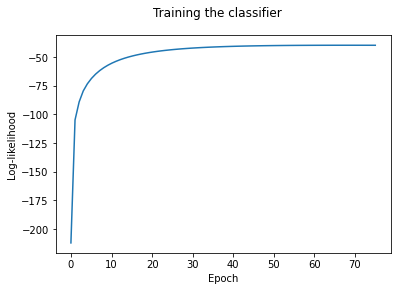

Training Accuracy 0.9972972972972973
Testing Accuracy 0.956989247311828
-56.22282557673990753


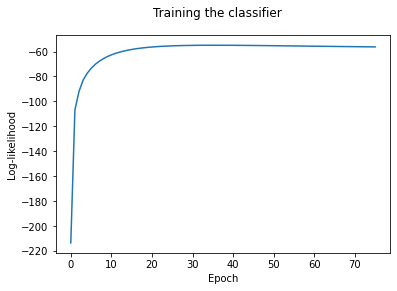

Training Accuracy 0.9972972972972973
Testing Accuracy 0.956989247311828
-68.137480007344776445


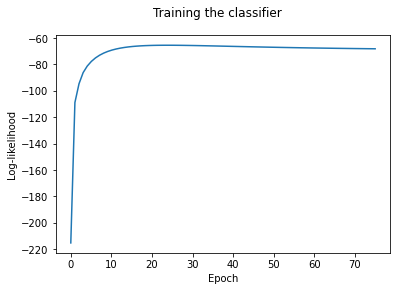

Training Accuracy 0.9945945945945946
Testing Accuracy 0.956989247311828
-77.38492979364873696


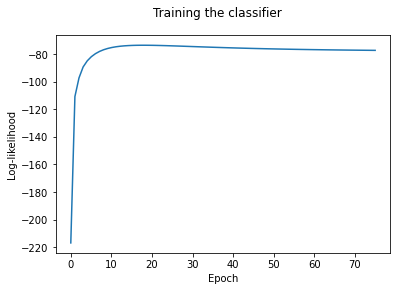

Training Accuracy 0.9945945945945946
Testing Accuracy 0.956989247311828
-46.923201738492914453


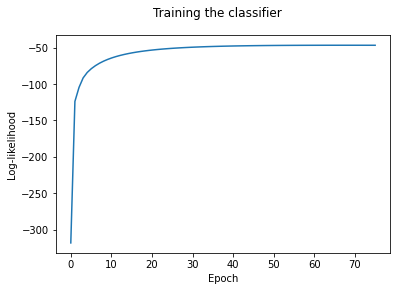

Training Accuracy on full data 0.9978401727861771
478
Testing Accuracy on Test Data 0.9456066945606695
[[339   9]
 [ 17 113]]
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       348
         1.0       0.93      0.87      0.90       130

    accuracy                           0.95       478
   macro avg       0.94      0.92      0.93       478
weighted avg       0.95      0.95      0.95       478

enron1
450
9688
X_train : (360, 9688)
y_train : (360,)
X_test : (90, 9688)
-38.682362833304420838


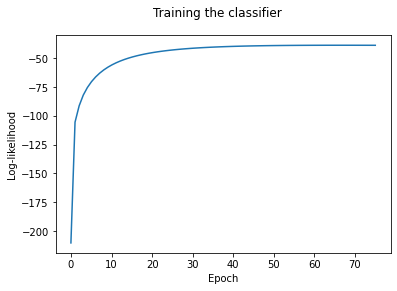

Training Accuracy 1.0
Testing Accuracy 0.9777777777777777
-55.91174840355200176


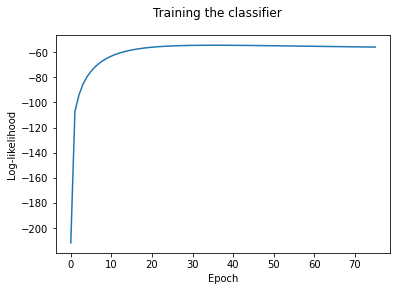

Training Accuracy 1.0
Testing Accuracy 0.9777777777777777
-68.36441487216601539


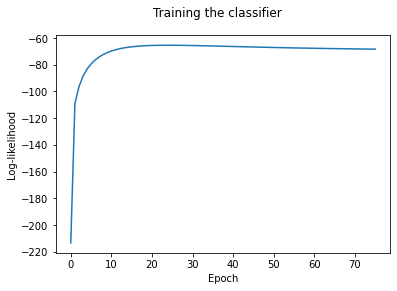

Training Accuracy 1.0
Testing Accuracy 0.9777777777777777
-78.01721863028946135


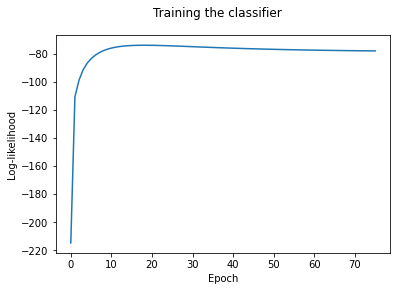

Training Accuracy 0.9972222222222222
Testing Accuracy 0.9666666666666667
-44.997502325286374454


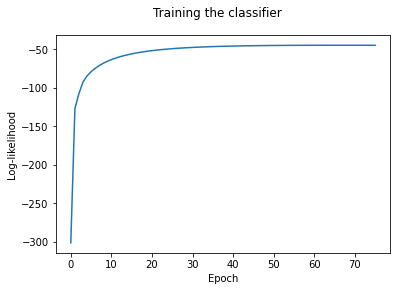

Training Accuracy on full data 1.0
456
Testing Accuracy on Test Data 0.9495614035087719
[[294  13]
 [ 10 139]]
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       307
         1.0       0.91      0.93      0.92       149

    accuracy                           0.95       456
   macro avg       0.94      0.95      0.94       456
weighted avg       0.95      0.95      0.95       456

enron4
535
17343
X_train : (428, 17343)
y_train : (428,)
X_test : (107, 17343)
-35.898240979416625066


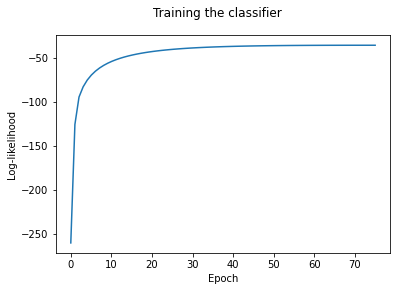

Training Accuracy 0.9976635514018691
Testing Accuracy 0.9532710280373832
-52.378982131050044822


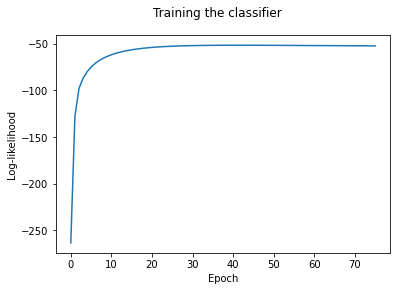

Training Accuracy 0.9976635514018691
Testing Accuracy 0.9532710280373832
-64.28003916756605014


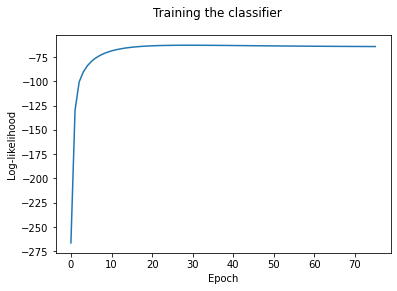

Training Accuracy 0.9953271028037384
Testing Accuracy 0.9439252336448598
-73.511019477407309214


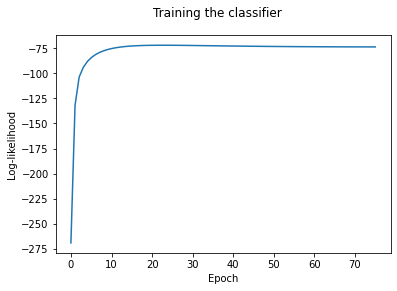

Training Accuracy 0.9883177570093458
Testing Accuracy 0.9439252336448598
-41.780982462699909306


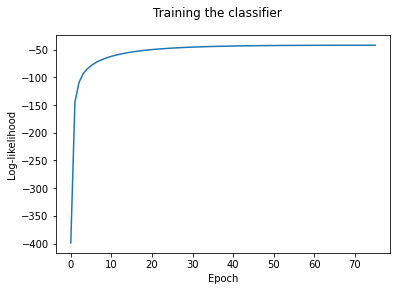

Training Accuracy on full data 0.9981308411214953
543
Testing Accuracy on Test Data 0.9631675874769797
[[132  20]
 [  0 391]]
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93       152
         1.0       0.95      1.00      0.98       391

    accuracy                           0.96       543
   macro avg       0.98      0.93      0.95       543
weighted avg       0.96      0.96      0.96       543



In [14]:
train()